In [2]:
%matplotlib inline

import os, glob
import numpy as np
import pandas as pd
from matplotlib import mlab
import matplotlib.pyplot as plt
import requests
import geopandas as gp
import fiona
from shapely.geometry import Point

# Air Quality

In [3]:
def read_data():
    aq_list = !ls '../../../Data/NYC_AQ/'*.csv

    df1 = []
    for i in aq_list:
        df = pd.read_csv(i)
        df1.append(df)

    data = pd.concat(df1)    
    data['timestamp'] = pd.to_datetime(data['Date(YYYY-MM-DD)'] + ' ' + data['Time (HH24:MI)'])
    data.index = data['timestamp']
    data = data.sort_index()
    data.drop(['timestamp','Date(YYYY-MM-DD)', 'Time (HH24:MI)'], axis=1, inplace=True)
    
    # clean up column names
    data.columns = data.columns.map(lambda x: " ".join(x.split(' ')[:-2]))    
    
    # remove some crazy outlier
    data['IS 52']['2015-02-05 13:00:00'] = np.nan
    data['IS 52']['2016-02-24 12:00:00'] = np.nan
    data['Port Richmond']['2007':'2010'] = np.nan
    
    return data

In [4]:
# build geometry
def create_geom(x):
    point = Point(x['longitude'],x['latitude'])
    return point

def get_station_locations():
    site = 'https://data.ny.gov/resource/7i2s-kiup.json'
    
    # This list was created manually
    site_names = ['JHS 45', 'IS 143','PS 19','Division Street','CCNY','Morrisania II','IS 52'
            ,'IS 74', 'Pfizer Lab', 'PS 314', 'JHS 126', 'PS 274', 'Maspeth','Queens College'
            ,'Susan Wagner HS','Port Richmond', 'Fresh Kills West']
    
    # request data from api
    r = requests.get(site)
    # convert to dataframe
    df = pd.DataFrame(r.json())
    
    # subset based on the region
    df = df[df['region'] == '2']
    df['site_name'] = site_names
    
    # build geometry
    df.loc[:,'longitude'] = df['longitude'].astype(float)
    df.loc[:,'latitude'] = df['latitude'].astype(float)    
    df['geometry'] = df.apply(create_geom, axis=1) 
    
    return df[['site_name','latitude','longitude', 'geometry']]

In [349]:
def generate_grid(crs, numcols=50, numrows=50):
    '''Function to create an evenly spaced point grid with crs'''

    xmin, xmax, ymin, ymax = 900000, 1080000, 120000, 280000

    xc = np.linspace(xmin, xmax, numcols)
    yc = np.linspace(ymin, ymax, numrows)

    pts = gp.GeoDataFrame(geometry=[Point(i,j) for i in xc for j in yc], crs=crs)

    return pts

In [5]:
# -- 
# Read AQ Data and Station Locations
# --
data = read_data()
station_locations = get_station_locations()
dec_sites = station_locations[station_locations['site_name'].isin(data.columns)]

In [8]:
# -- Read NYC geometry
nybb_path = gp.datasets.get_path('nybb')
boros = gp.GeoDataFrame.from_file(nybb_path)

Regression Model

$ pm25_{ij} = \beta_0 + \beta_1 \bar{c}_j + \beta_2 b $ 

where $pm25_{ij}$ is the PM25 concentration for location $i$ at time $j$, $\bar{c}_j$ is the citywide average PM2.5 level and $b$ is the number of oil-burning units (#2,4,6) within a 1km radius.

# Boilers

In [35]:
def create_BoroCode(x):
    if x == 'MANHATTAN':
        return '1'
    elif x == 'BRONX':
        return '2'
    elif x == 'BROOKLYN':
        return '3'
    elif x == 'QUEENS':
        return '4'
    elif x == 'STATENISLAND':
        return '5'
    else:
        print "Not Valid"
        
def process_boilers(df):
    # -- subset for only boilers 2,4,6
    df = df[df['PrimaryFuel'].isin(['NO2FUEL','NO4FUEL','HO6FUEL','NO2FUELB2'])]
    
    # -- 82 entries do not have Block/Lot data
    df = df[df['Lot'].notnull()]
    df = df[df['Block'].notnull()]
    df = df[df['Borough'].notnull()]
    
    # -- Change data type
    df[['Block','Lot']] = df[['Block','Lot']].astype(int).astype(str)

    # -- Add zero padding to generate BBL string
    df['Lot'] = df['Lot'].map(lambda x: x.zfill(4))
    df['Block'] = df['Block'].map(lambda x: x.zfill(5))    
    
    # --
    # Crate BBL
    # --
    #
    # -- BBL = BoroCode (1 digit) + Tax Block (5 digits) + Tax Lot (4 digits)
    
    # -- Create BoroCode numbers from boro name
    df['BoroCode'] = df['Borough'].map(create_BoroCode)    
    
    # -- Create BBL from BoroCode, Block, Lot
    df['BBL'] = df[['BoroCode','Block','Lot']].apply(lambda x: ''.join(x), axis=1)    
    
    return df

In [36]:
# -- Read DEP Boiler Permits
boilerPath = '../../../Data/DEP/CATS_Permits.csv'
boilers = pd.read_csv(boilerPath)
print "Boilers Shape: {}".format(boilers.shape)
boilers = process_boilers(boilers)

# PLUTO

In [55]:
def process_pluto(df):
    print 'Processing MapPLUTO...'
    
    # -- Set BBL to str type
    df['BBL'] = df['BBL'].astype(int).astype(str)
    
    print 'Final Pluto Shape: {}'.format(df.shape)
    return df

def read_pluto(fpath, cols=['BBL','LandUse','geometry']):
    '''Read MapPLUTO shapefiles'''
    
    pl = []
    for file in glob.glob(fpath):
        print(file)
        gdf = gp.read_file(file)
        pl.append(gdf[cols])

    df = pd.concat(pl, ignore_index=True)    
    
    print 'Pluto Shape: {}'.format(df.shape)
    return df

In [225]:
fpath = '../../../Data/MapPLUTO_16v1/*/*MapPLUTO.shp'    
pluto = read_pluto(fpath)
pluto = process_pluto(pluto)

../../../Data/MapPLUTO_16v1/Bronx/BXMapPLUTO.shp
../../../Data/MapPLUTO_16v1/Brooklyn/BKMapPLUTO.shp
../../../Data/MapPLUTO_16v1/Manhattan/MNMapPLUTO.shp
../../../Data/MapPLUTO_16v1/Queens/QNMapPLUTO.shp

Either a polygon with interior rings, or a polygon with less than 4 points,
or a non-Polygon geometry.  Return arguments as a collection.



../../../Data/MapPLUTO_16v1/Staten_Island/SIMapPLUTO.shp
Pluto Shape: (857216, 3)
Processing MapPLUTO...

Ring Self-intersection at or near point 1007751.8059999943 264938.51000000536
Ring Self-intersection at or near point 979034.81360000372 196814.58959999681
Too few points in geometry component at or near point 1041980.7877999991 154413.05500000715
Ring Self-intersection at or near point 928158.86439999938 141708.78779999912
Ring Self-intersection at or near point 955654.51620000601 157225.08300000429



Final Pluto Shape: (857211, 3)


/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---

# Merge PLUTO w/ Boiler

(50577, 25)


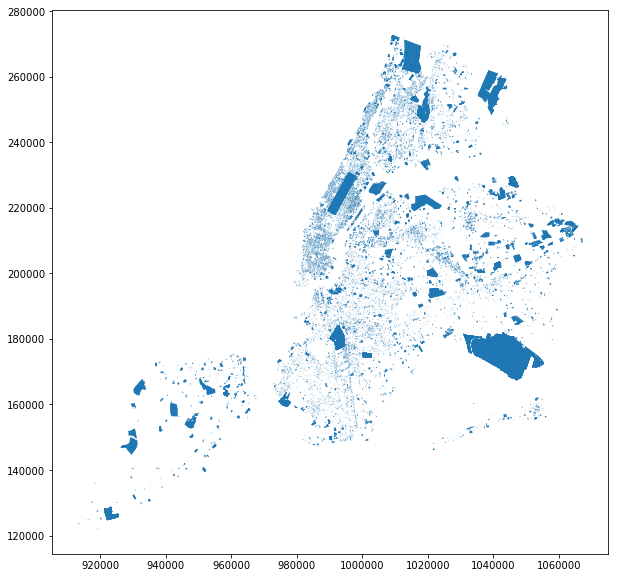

In [340]:
# --
# Merge Boiler and Pluto data on bbl
# --
boilers_pl = gp.GeoDataFrame(boilers.merge(pluto, on='BBL'))
print boilers_pl.shape
boilers_pl.plot(figsize=(10,10))

# Spatial Join to get boiler counts <1km

In [343]:
# --
# Set Standards CRS
# --
original_crs = pluto.crs
original_crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

In [ ]:
# -- create evenly spaced grid
pts = generate_grid(crs=pluto.crs)
grid_pts = gp.sjoin(pts, boros, how='inner', op='within')

In [344]:
boilers_pl.crs = original_crs
boilers_pl = boilers_pl.to_crs(crs=original_crs)

In [345]:
outFile = '../data/boilers_pluto.shp'

In [347]:
pts.to_file('../data/grid_pts/grid_pts.shp')

In [346]:
boilers_pl.to_file(outFile)